# Runner

In [1]:
from utils.setting import config
import numpy as np
from model.sampler import GaussianMixtureSampler
import numpy as np
import matplotlib.pyplot as plt
from model.conformal_dra import ConformalizedDecisionRiskAssessment
from model.naive_dra import NaiveDecisionRiskAssessment 

def synthetic_experiment(mu, scale, weights, ntr, ncal, k, A, b):

    sampler_kwds = {
        'mu':       mu,     # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    scale,  # [ ncomp ] np, the variance of GMs 
        'weights':  weights # [ ncomp ]
    }
    sampler     = GaussianMixtureSampler(**sampler_kwds)

    Ytr         = sampler.sample(ntr)       # [ ntr, data_dim ]
    Ycal        = sampler.sample(ncal)      # [ ncal, data_dim ]

    # Fair Gaussian distribution
    Y = np.concatenate([Ytr, Ycal], 0)      # [ ntr + ncal, data_dim ]
    fair_kwds = {
        'mu':       Y.mean(0)[None, :],                     # [ 1, data_dim ] np, the mean of GMs
        'cov':      np.cov(Y, rowvar=False)[None, :, :],    # [ 1 ] np, the variance of GMs 
    }
    # Estimated Gaussian distribution
    placeholder_kwds = {
        'mu':       np.zeros(sampler_kwds['mu'].shape),
        'scale':    np.ones(sampler_kwds['scale'].shape),                                 # [ ncomp ] np, the variance of GMs 
        'weights':  np.ones(sampler_kwds['scale'].shape) / len(sampler_kwds['scale']),    # [ ncomp ] np, the variance of GMs 
    }
    pred_sampler = GaussianMixtureSampler(**placeholder_kwds)
    model_kwds = pred_sampler.fit(Ytr, n_iter=100, return_kwds=True)

    # Point prediction model / Predict-Then-Optimize Model
    point_model_kwds = {
        'mu':       Ytr.mean(0)[None, :],                           # [ 1, data_dim ] np, the mean of GMs
        'scale':    np.array([1e-5]),
    }

    # Initialize DRA Models
    true_kwds = {
        'A':    A,
        'b':    b,
        'kwds': sampler_kwds,
        'boundary_scale':   10
    }

    naive_kwds = {
        'A':    A,
        'b':    b,
        'kwds': fair_kwds,
        'boundary_scale':   10   
    }

    kwds = {
        'A':    A,
        'b':    b,
        'kwds': model_kwds,
        'boundary_scale':   10
    }

    point_kwds = {
        'A':    A,
        'b':    b,
        'kwds': point_model_kwds,
        'boundary_scale':   10
    }

    # All baseline models
    true_dra    = NaiveDecisionRiskAssessment(**true_kwds) 
    naive_dra   = NaiveDecisionRiskAssessment(**naive_kwds)
    dra         = ConformalizedDecisionRiskAssessment(**kwds)
    point_dra   = ConformalizedDecisionRiskAssessment(**point_kwds)

    # Two models that needs to calibrate first
    dra.calibrate(Ycal)
    point_dra.calibrate(Ycal)

    a = dra.get_prob(K = k)
    b = naive_dra.get_prob(K = k)
    c = point_dra.get_prob(K = k)
    d = true_dra.get_prob(K = 10000)

    return a, b, c, d

def conservativeness_rate(r, r4):
    '''
    Conservativeness rate

    Args:
    - r:    [ num_seq, num_decision ], estimated matrix
    - r4:   [ num_seq, num_decision ], true_prob matrix
    '''
    mask = r <= r4      # [ num_seq, 3 ]
    out = mask.mean(1)  # [ num_seq ]
    return out 

def relative_accuracy(r, r4):
    '''
    Relative accuracy

    Args:
    - r:    [ num_seq, ntrial, num_decision ], estimated matrix
    - r4:   [ num_seq, ntrial, num_decision ], true_prob matrix
    '''
    mask    = - np.abs(r - r4)  # [ num_seq, ntrials ,3 ]
    out     =   mask.mean(-1)   # [ num_seq, ntrial ]
    return out

def true_positive_rate(r, r4):
    '''
    True postiive rate

    Args:
    - r:    [ num_seq, ntrial, num_decision ], estimated matrix
    - r4:   [ num_seq, ntrial, num_decision ], true_prob matrix
    '''
    mask_est =  r > 0
    mask_true = r4 > 0
    TP_est = np.logical_and(mask_est, mask_true).mean(-1)
    return TP_est # [ num_seq, ntrial ]

In [2]:
from utils.setting import config
import numpy as np
from model.sampler import GaussianMixtureSampler
import numpy as np
import matplotlib.pyplot as plt
from model.conformal_dra import ConformalizedDecisionRiskAssessment
from model.naive_dra import NaiveDecisionRiskAssessment 

# Setting I

## Validity vs. Methods

In [3]:
from tqdm import tqdm

config()

xs = np.arange(1, 100)

A, B, C, D = [], [], [], []
for x in tqdm(xs):
    kwds = {
        'mu':       np.array([[-1e-1, -1e-1]]),    # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1]),                 # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([1.0]),               # [ ncomp ]
        'ntr':  100,
        'ncal': 100,
        'k':    100,
        'A':    np.array([
            [1,    1],
            [-1,   0],
            [0,   -1]
        ]),
        'b':    np.array([1, 0, 0])
    }
    a, b, c, d = synthetic_experiment(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)

100%|██████████| 99/99 [00:04<00:00, 21.00it/s]


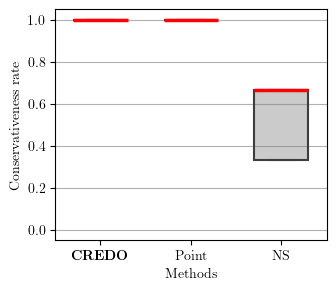

In [4]:
import seaborn as sns

name = [ r'\textbf{CREDO}', 'Point', 'NS']
plt_data = np.stack([conservativeness_rate(A, D), conservativeness_rate(C, D), conservativeness_rate(B, D)], 1)
cmap = plt.cm.tab10
colors = [cmap(i) for i in range(3)]

plt.figure(figsize=[3.5, 3])
ax = sns.boxplot(data=plt_data, linewidth=1.5, width=0.6, color='tab:gray')

# Highlight median lines
for line in ax.artists:
    line.set_edgecolor('black')     # outline of box
for median_line in ax.lines[4::6]:  # median lines in seaborn's internal boxplot drawing order
    median_line.set_color('red')
    median_line.set_linewidth(2.5)

for patch in ax.patches:
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.4))  # Set desired alpha

plt.ylabel('Conservativeness rate')
plt.xlabel('Methods')
plt.xticks(np.arange(0, 3), name)
plt.ylim(-0.05, 1.05)
plt.grid(axis = 'y')
plt.show()

## Risk vs. Methods

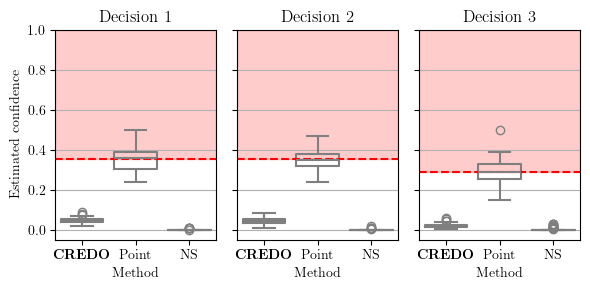

In [5]:
import pandas as pd

name = [ r'\textbf{CREDO}', 'Point', 'NS']

methods     = [r'\textbf{CREDO}', 'Point', 'NS']
data_list   = [A, B, C]  # A, B, C are arrays of shape (n_samples, n_decisions)
n_decisions = A.shape[1]

fig, axes = plt.subplots(1, n_decisions, figsize=(2 * n_decisions, 3), sharey=True)

for i in range(n_decisions):
    # Prepare long-format DataFrame for violin plot
    df = pd.DataFrame({
        'Estimated confidence': np.concatenate([M[:, i] for M in data_list]),
        'Method': np.concatenate([[methods[j]] * len(data_list[j]) for j in range(len(data_list))])
    })
    sns.boxplot(x='Method', y='Estimated confidence', data=df, ax=axes[i], fill=False, color = 'tab:gray')
    axes[i].set_title(f'Decision {i+1}')
    axes[i].axhline(D[:, i].mean(), color ='red', ls = '--')
    axes[i].axhspan(D[:, i].mean(), 1.0, color='red', alpha=0.2)
    axes[i].set_ylim(None, 1.0)
    axes[i].grid(axis = 'y')

plt.tight_layout()
plt.show()

## TPR vs. K 

In [6]:
from tqdm import tqdm

config()

xs = np.arange(1, 100)
ntrial = 20

A, B, C, D = [], [], [], []
for x in tqdm(xs):
    as_, bs_, cs_, ds_ = [], [], [], []
    for trial in range(ntrial):
        kwds = {
            'mu':       np.array([[-1e-1, -1e-1]]),    # [ ncomp, data_dim ] np, the mean of GMs
            'scale':    np.array([1]),                 # [ ncomp ] np, the variance of GMs 
            'weights':  np.array([1.0]),               # [ ncomp ]
            'ntr':  100,
            'ncal': 100,
            'k':    x,
            'A':    np.array([
                [1,    1],
                [-1,   0],
                [0,   -1]
            ]),
            'b':    np.array([1, 0, 0])
        }
        a, b, c, d = synthetic_experiment(**kwds)
    
        A.append(a)
        B.append(b)
        C.append(c)
        D.append(d)

A = np.array(A).reshape(len(xs), ntrial, len(kwds['A']))
B = np.array(B).reshape(len(xs), ntrial, len(kwds['A']))
C = np.array(C).reshape(len(xs), ntrial, len(kwds['A']))
D = np.array(D).reshape(len(xs), ntrial, len(kwds['A'])) # all [ n_xs, ntrial, num_decisions ]

100%|██████████| 99/99 [01:01<00:00,  1.60it/s]


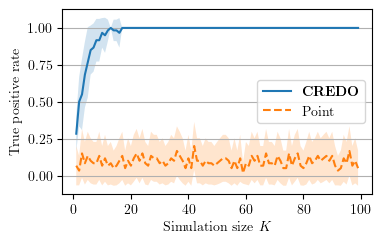

In [7]:
name = [ r'\textbf{CREDO}', 'Point' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, true_positive_rate(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 true_positive_rate(A, D).mean(1) - true_positive_rate(A, D).std(1),
                 true_positive_rate(A, D).mean(1) + true_positive_rate(A, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 true_positive_rate(C, D).mean(1) - true_positive_rate(C, D).std(1),
                 true_positive_rate(C, D).mean(1) + true_positive_rate(C, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('True positive rate')
plt.xlabel(r'Simulation size $K$')
plt.legend(loc=  'center right')
plt.show()

## TPR vs. K (w/ NS)

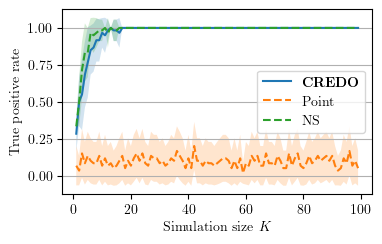

In [8]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, true_positive_rate(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 true_positive_rate(A, D).mean(1) - true_positive_rate(A, D).std(1),
                 true_positive_rate(A, D).mean(1) + true_positive_rate(A, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 true_positive_rate(C, D).mean(1) - true_positive_rate(C, D).std(1),
                 true_positive_rate(C, D).mean(1) + true_positive_rate(C, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 true_positive_rate(B, D).mean(1) - true_positive_rate(B, D).std(1),
                 true_positive_rate(B, D).mean(1) + true_positive_rate(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('True positive rate')
plt.xlabel(r'Simulation size $K$')
plt.legend(loc=  'center right')
plt.show()

## Rel Acc. vs. K (w/ NS)

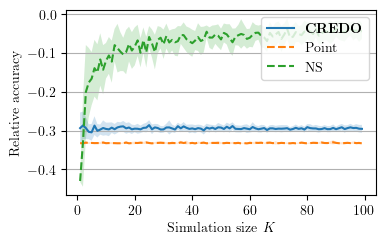

In [9]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, relative_accuracy(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 relative_accuracy(A, D).mean(1) - relative_accuracy(A, D).std(1),
                 relative_accuracy(A, D).mean(1) + relative_accuracy(A, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 relative_accuracy(C, D).mean(1) - relative_accuracy(C, D).std(1),
                 relative_accuracy(C, D).mean(1) + relative_accuracy(C, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 relative_accuracy(B, D).mean(1) - relative_accuracy(B, D).std(1),
                 relative_accuracy(B, D).mean(1) + relative_accuracy(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('Relative accuracy')
plt.xlabel(r'Simulation size $K$')
plt.legend(loc=  'upper right')
plt.show()

## TPR vs. Var (w/ NS)

In [10]:
from tqdm import tqdm

config()

xs = 10**np.linspace(-3, 1, 200)
ntrial = 20

A, B, C, D = [], [], [], []
for x in tqdm(xs):
    as_, bs_, cs_, ds_ = [], [], [], []
    for trial in range(ntrial):
        kwds = {
            'mu':       np.array([[-1e-1, -1e-1]]),    # [ ncomp, data_dim ] np, the mean of GMs
            'scale':    np.array([1]) * x,                 # [ ncomp ] np, the variance of GMs 
            'weights':  np.array([1.0]),               # [ ncomp ]
            'ntr':  100,
            'ncal': 100,
            'k':    100,
            'A':    np.array([
                [1,    1],
                [-1,   0],
                [0,   -1]
            ]),
            'b':    np.array([1, 0, 0])
        }
        a, b, c, d = synthetic_experiment(**kwds)
    
        A.append(a)
        B.append(b)
        C.append(c)
        D.append(d)

A = np.array(A).reshape(len(xs), ntrial, len(kwds['A']))
B = np.array(B).reshape(len(xs), ntrial, len(kwds['A']))
C = np.array(C).reshape(len(xs), ntrial, len(kwds['A']))
D = np.array(D).reshape(len(xs), ntrial, len(kwds['A'])) # all [ n_xs, ntrial, num_decisions ]

100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


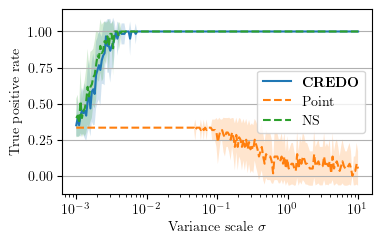

In [11]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, true_positive_rate(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 true_positive_rate(A, D).mean(1) - true_positive_rate(A, D).std(1),
                 true_positive_rate(A, D).mean(1) + true_positive_rate(A, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 true_positive_rate(C, D).mean(1) - true_positive_rate(C, D).std(1),
                 true_positive_rate(C, D).mean(1) + true_positive_rate(C, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 true_positive_rate(B, D).mean(1) - true_positive_rate(B, D).std(1),
                 true_positive_rate(B, D).mean(1) + true_positive_rate(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('True positive rate')
plt.xlabel(r'Variance scale $\sigma$')
plt.xscale('log')
plt.legend(loc=  'center right')
plt.show()

## Rel Acc vs. Var

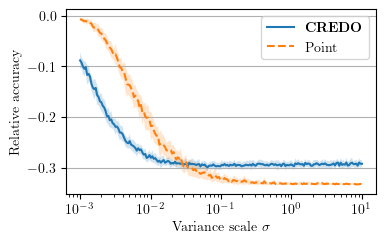

In [12]:
name = [ r'\textbf{CREDO}', 'Point' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, relative_accuracy(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 relative_accuracy(A, D).mean(1) - relative_accuracy(A, D).std(1),
                 relative_accuracy(A, D).mean(1) + relative_accuracy(A, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 relative_accuracy(C, D).mean(1) - relative_accuracy(C, D).std(1),
                 relative_accuracy(C, D).mean(1) + relative_accuracy(C, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('Relative accuracy')
plt.xlabel(r'Variance scale $\sigma$')
plt.xscale('log')
plt.legend(loc=  'upper right')
plt.show()

## Rel Acc vs. Var (w/ NS)

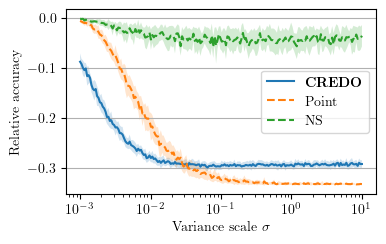

In [13]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, relative_accuracy(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 relative_accuracy(A, D).mean(1) - relative_accuracy(A, D).std(1),
                 relative_accuracy(A, D).mean(1) + relative_accuracy(A, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 relative_accuracy(C, D).mean(1) - relative_accuracy(C, D).std(1),
                 relative_accuracy(C, D).mean(1) + relative_accuracy(C, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 relative_accuracy(B, D).mean(1) - relative_accuracy(B, D).std(1),
                 relative_accuracy(B, D).mean(1) + relative_accuracy(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('Relative accuracy')
plt.xlabel(r'Variance scale $\sigma$')
plt.xscale('log')
plt.legend(loc=  'center right')
plt.show()

# Setting II

## Validity vs. Methods

In [14]:
from tqdm import tqdm

config()

xs = np.arange(1, 100)

A, B, C, D = [], [], [], []
for x in tqdm(xs):
    kwds = {
        'mu':       np.array([[0.0, -0.8],
                            [-0.5, 0.25],
                            [0.8, -0.1]]),  # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1e-2, 3e-2, 2e-2]),                                # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([0.3, 0.4, 0.3]),                                # [ ncomp ] np, the variance of GMs 
        'ntr':  100,
        'ncal': 100,
        'k':    100,
        'A':    np.array([
            [-1/2, -1],
            [0,   -1],
            [-1/2, 1],
            [1/2,  1],
            [2,   -1],
            [1, 0],
            [0, 1],
            [-1, 0]
        ]),
        'b':    np.array([-1, 0, 1, 5, 10, 5.5, 2.5, -1])
    }
    a, b, c, d = synthetic_experiment(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)

100%|██████████| 99/99 [00:06<00:00, 16.13it/s]


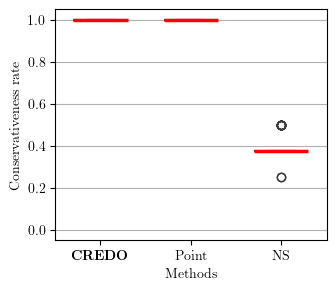

In [15]:
import seaborn as sns

name = [ r'\textbf{CREDO}', 'Point', 'NS']
plt_data = np.stack([conservativeness_rate(A, D), conservativeness_rate(C, D), conservativeness_rate(B, D)], 1)
cmap = plt.cm.tab10
colors = [cmap(i) for i in range(3)]

plt.figure(figsize=[3.5, 3])
ax = sns.boxplot(data=plt_data, linewidth=1.5, width=0.6, color='tab:gray')

# Highlight median lines
for line in ax.artists:
    line.set_edgecolor('black')     # outline of box
for median_line in ax.lines[4::6]:  # median lines in seaborn's internal boxplot drawing order
    median_line.set_color('red')
    median_line.set_linewidth(2.5)

for patch in ax.patches:
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.4))  # Set desired alpha

plt.ylabel('Conservativeness rate')
plt.xlabel('Methods')
plt.xticks(np.arange(0, 3), name)
plt.ylim(-0.05, 1.05)
plt.grid(axis = 'y')
plt.show()

## Risk vs. Methods

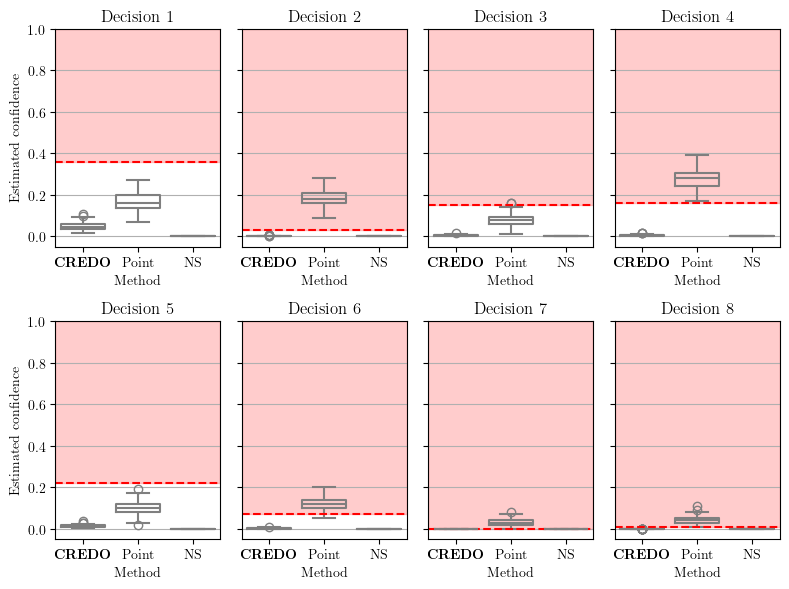

In [16]:
import pandas as pd

name = [ r'\textbf{CREDO}', 'Point', 'NS']

methods     = [r'\textbf{CREDO}', 'Point', 'NS']
data_list   = [A, B, C]  # A, B, C are arrays of shape (n_samples, n_decisions)
n_decisions = A.shape[1]

fig, axes = plt.subplots(2, 4, figsize=(2 * n_decisions // 2, 6), sharey=True)

axes = axes.reshape(-1)
for i in range(n_decisions):
    # Prepare long-format DataFrame for violin plot
    df = pd.DataFrame({
        'Estimated confidence': np.concatenate([M[:, i] for M in data_list]),
        'Method': np.concatenate([[methods[j]] * len(data_list[j]) for j in range(len(data_list))])
    })
    sns.boxplot(x='Method', y='Estimated confidence', data=df, ax=axes[i], fill=False, color = 'tab:gray')
    axes[i].set_title(f'Decision {i+1}')
    axes[i].axhline(D[:, i].mean(), color ='red', ls = '--')
    axes[i].axhspan(D[:, i].mean(), 1.0, color='red', alpha=0.2)
    axes[i].set_ylim(None, 1.0)
    axes[i].grid(axis = 'y')

plt.tight_layout()
plt.show()

## TPR vs. K

In [17]:
from tqdm import tqdm

config()

xs = np.arange(1, 100)
ntrial = 20

A, B, C, D = [], [], [], []
for x in tqdm(xs):
    as_, bs_, cs_, ds_ = [], [], [], []
    for trial in range(ntrial):
        kwds = {
            'mu':       np.array([[0.0, -0.8],
                                [-0.5, 0.25],
                                [0.8, -0.1]]),  # [ ncomp, data_dim ] np, the mean of GMs
            'scale':    np.array([1e-2, 3e-2, 2e-2]),                                # [ ncomp ] np, the variance of GMs 
            'weights':  np.array([0.3, 0.4, 0.3]),                                # [ ncomp ] np, the variance of GMs 
            'ntr':  100,
            'ncal': 100,
            'k':    x,
            'A':    np.array([
                [-1/2, -1],
                [0,   -1],
                [-1/2, 1],
                [1/2,  1],
                [2,   -1],
                [1, 0],
                [0, 1],
                [-1, 0]
            ]),
            'b':    np.array([-1, 0, 1, 5, 10, 5.5, 2.5, -1])
        }
        a, b, c, d = synthetic_experiment(**kwds)
    
        A.append(a)
        B.append(b)
        C.append(c)
        D.append(d)

A = np.array(A).reshape(len(xs), ntrial, len(kwds['A']))
B = np.array(B).reshape(len(xs), ntrial, len(kwds['A']))
C = np.array(C).reshape(len(xs), ntrial, len(kwds['A']))
D = np.array(D).reshape(len(xs), ntrial, len(kwds['A'])) # all [ n_xs, ntrial, num_decisions ]

100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


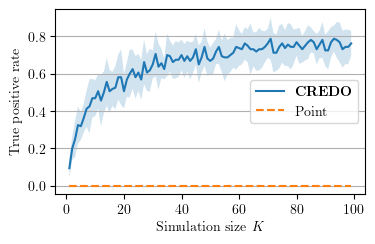

In [18]:
name = [ r'\textbf{CREDO}', 'Point' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, true_positive_rate(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 true_positive_rate(A, D).mean(1) - true_positive_rate(A, D).std(1),
                 true_positive_rate(A, D).mean(1) + true_positive_rate(A, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 true_positive_rate(C, D).mean(1) - true_positive_rate(C, D).std(1),
                 true_positive_rate(C, D).mean(1) + true_positive_rate(C, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('True positive rate')
plt.xlabel(r'Simulation size $K$')
plt.legend(loc=  'center right')
plt.show()

## TPR vs. K (w/ NS)

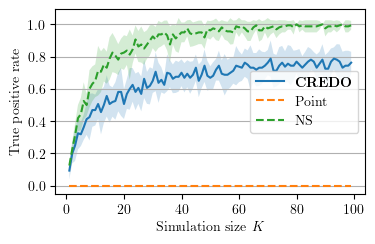

In [19]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, true_positive_rate(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 true_positive_rate(A, D).mean(1) - true_positive_rate(A, D).std(1),
                 true_positive_rate(A, D).mean(1) + true_positive_rate(A, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 true_positive_rate(C, D).mean(1) - true_positive_rate(C, D).std(1),
                 true_positive_rate(C, D).mean(1) + true_positive_rate(C, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 true_positive_rate(B, D).mean(1) - true_positive_rate(B, D).std(1),
                 true_positive_rate(B, D).mean(1) + true_positive_rate(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('True positive rate')
plt.xlabel(r'Simulation size $K$')
plt.legend(loc=  'center right')
plt.show()

## Rel Acc vs. K (w/ NS)

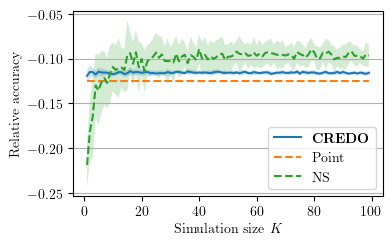

In [20]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, relative_accuracy(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 relative_accuracy(A, D).mean(1) - relative_accuracy(A, D).std(1),
                 relative_accuracy(A, D).mean(1) + relative_accuracy(A, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 relative_accuracy(C, D).mean(1) - relative_accuracy(C, D).std(1),
                 relative_accuracy(C, D).mean(1) + relative_accuracy(C, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 relative_accuracy(B, D).mean(1) - relative_accuracy(B, D).std(1),
                 relative_accuracy(B, D).mean(1) + relative_accuracy(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('Relative accuracy')
plt.xlabel(r'Simulation size $K$')
plt.legend(loc=  'lower right')
plt.show()

## TPR vs. Var (w/ NS)

In [21]:
from tqdm import tqdm

config()

xs = 10**np.linspace(-3, 1, 200)
ntrial = 20

A, B, C, D = [], [], [], []
for x in tqdm(xs):
    as_, bs_, cs_, ds_ = [], [], [], []
    for trial in range(ntrial):
        kwds = {
            'mu':       np.array([[0.0, -0.8],
                                [-0.5, 0.25],
                                [0.8, -0.1]]),  # [ ncomp, data_dim ] np, the mean of GMs
            'scale':    np.array([1e-2, 3e-2, 2e-2]) * x,                                # [ ncomp ] np, the variance of GMs 
            'weights':  np.array([0.3, 0.4, 0.3]),                                # [ ncomp ] np, the variance of GMs 
            'ntr':  100,
            'ncal': 100,
            'k':    100,
            'A':    np.array([
                [-1/2, -1],
                [0,   -1],
                [-1/2, 1],
                [1/2,  1],
                [2,   -1],
                [1, 0],
                [0, 1],
                [-1, 0]
            ]),
            'b':    np.array([-1, 0, 1, 5, 10, 5.5, 2.5, -1])
        }
        a, b, c, d = synthetic_experiment(**kwds)
    
        A.append(a)
        B.append(b)
        C.append(c)
        D.append(d)

A = np.array(A).reshape(len(xs), ntrial, len(kwds['A']))
B = np.array(B).reshape(len(xs), ntrial, len(kwds['A']))
C = np.array(C).reshape(len(xs), ntrial, len(kwds['A']))
D = np.array(D).reshape(len(xs), ntrial, len(kwds['A'])) # all [ n_xs, ntrial, num_decisions ]

100%|██████████| 200/200 [04:10<00:00,  1.25s/it]


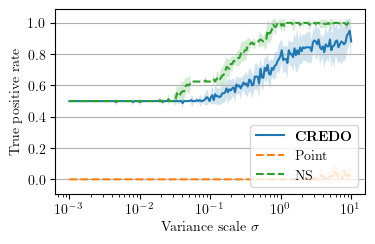

In [22]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, true_positive_rate(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 true_positive_rate(A, D).mean(1) - true_positive_rate(A, D).std(1),
                 true_positive_rate(A, D).mean(1) + true_positive_rate(A, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 true_positive_rate(C, D).mean(1) - true_positive_rate(C, D).std(1),
                 true_positive_rate(C, D).mean(1) + true_positive_rate(C, D).std(1), alpha = 0.2)
plt.plot(xs, true_positive_rate(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 true_positive_rate(B, D).mean(1) - true_positive_rate(B, D).std(1),
                 true_positive_rate(B, D).mean(1) + true_positive_rate(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('True positive rate')
plt.xlabel(r'Variance scale $\sigma$')
plt.xscale('log')
plt.legend(loc=  'lower right')
plt.show()

## Rel Acc vs. Var

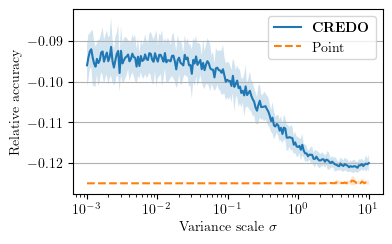

In [23]:
name = [ r'\textbf{CREDO}', 'Point' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, relative_accuracy(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 relative_accuracy(A, D).mean(1) - relative_accuracy(A, D).std(1),
                 relative_accuracy(A, D).mean(1) + relative_accuracy(A, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 relative_accuracy(C, D).mean(1) - relative_accuracy(C, D).std(1),
                 relative_accuracy(C, D).mean(1) + relative_accuracy(C, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('Relative accuracy')
plt.xlabel(r'Variance scale $\sigma$')
plt.xscale('log')
plt.legend(loc=  'upper right')
plt.show()

## Rel Acc vs. Var (w/ NS)

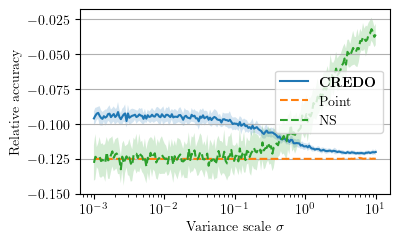

In [24]:
name = [ r'\textbf{CREDO}', 'Point', 'NS' ]

scale = 0.8
plt.figure(figsize = [5*scale, 3*scale])

plt.plot(xs, relative_accuracy(A, D).mean(1), label = name[0])
plt.fill_between(xs,
                 relative_accuracy(A, D).mean(1) - relative_accuracy(A, D).std(1),
                 relative_accuracy(A, D).mean(1) + relative_accuracy(A, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(C, D).mean(1), ls = '--',  label = name[1])
plt.fill_between(xs,
                 relative_accuracy(C, D).mean(1) - relative_accuracy(C, D).std(1),
                 relative_accuracy(C, D).mean(1) + relative_accuracy(C, D).std(1), alpha = 0.2)
plt.plot(xs, relative_accuracy(B, D).mean(1), ls = '--',  label = name[2])
plt.fill_between(xs,
                 relative_accuracy(B, D).mean(1) - relative_accuracy(B, D).std(1),
                 relative_accuracy(B, D).mean(1) + relative_accuracy(B, D).std(1), alpha = 0.2)

plt.grid(axis='y')
plt.ylabel('Relative accuracy')
plt.xlabel(r'Variance scale $\sigma$')
plt.xscale('log')
plt.legend(loc=  'center right')
plt.show()